# Linear Regression from Scratch

In this notebook, we build a linear regression model from scratch using the California Housing dataset. 
We'll walk through the following steps:

1. **Data Loading and Visualization**  
   - Import and inspect the dataset.
   - Visualize relationships between features and the target variable.

2. **Data Preprocessing**  
   - Convert geographical coordinates from spherical to Cartesian coordinates.
   - Standardize selected features and remove outliers.

3. **Model Initialization and Cost Computation**  
   - Define the cost function and initialize the model parameters.

4. **Gradient Descent Implementation**  
   - Compute gradients and update weights iteratively.
   - Monitor the cost function to verify convergence.

5. **Model Evaluation and Example Prediction**  
   - Evaluate model performance on the test set.
   - Make a prediction example.

**Mathematical Insights:**

The cost function (mean squared error) is defined as:
$$
\
J(w, b) = \frac{1}{2m} \sum_{i=1}^{m} (y_i - (w^T x_i + b))^2
$$

and the gradients are computed as:

$$
\
\frac{\partial J}{\partial w_j} = -\frac{1}{m} \sum_{i=1}^{m} (y_i - (w^T x_i + b)) x_{ij}, \quad \frac{\partial J}{\partial b} = -\frac{1}{m} \sum_{i=1}^{m} (y_i - (w^T x_i + b))
$$


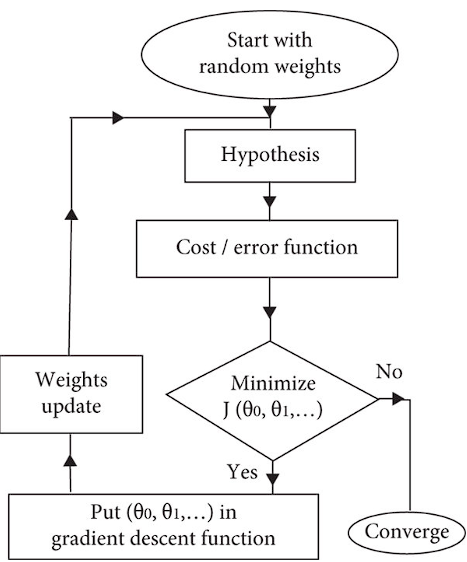

How the cost functions decreases with iterations:

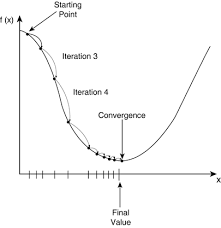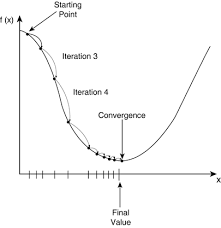s.


## 1. Data Loading and Visualization

We start by loading the California Housing dataset and visualizing the relationships between each feature and the target variable (housing price).

In [1]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy import stats
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt 
import math

**Loading the dataset:**

Here, we load the California Housing dataset. Note that we create a DataFrame for the features and a Series for the target prices.

In [2]:
cali = fetch_california_housing()

**Creating a DataFrame:**

In [3]:
cali_data = pd.DataFrame(cali.data, columns=cali.feature_names)
Price = pd.Series(cali.target)
cali_data.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


**Visualizing Feature Relationships:**

We generate scatter plots to examine how each feature correlates with the housing price.


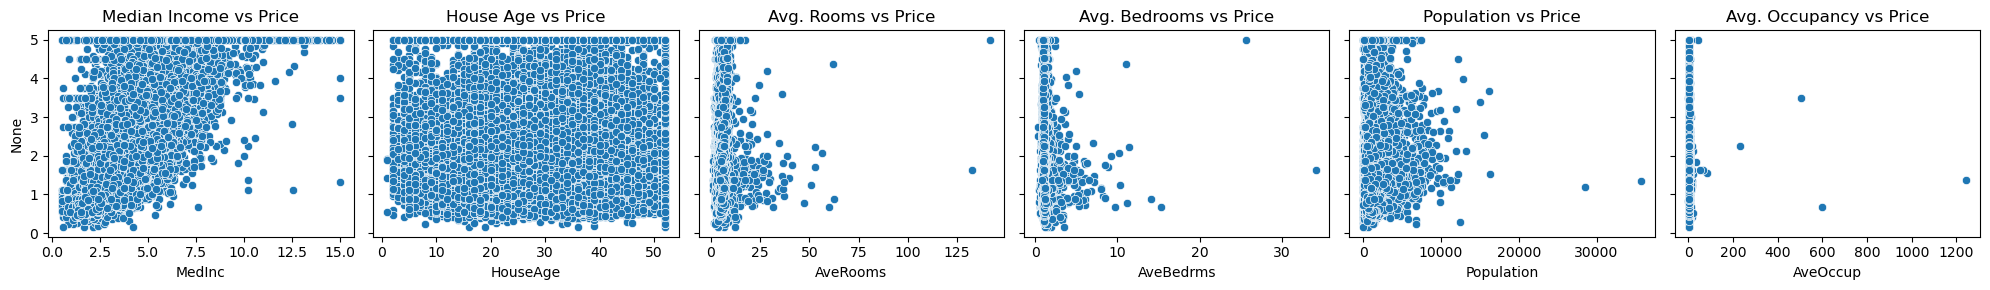

In [4]:
fig, axes = plt.subplots(1, 6, sharey=True, figsize=(20, 3))
sns.scatterplot(ax=axes[0], x=cali_data.MedInc, y=Price).set(title="Median Income vs Price")
sns.scatterplot(ax=axes[1], x=cali_data.HouseAge, y=Price).set(title="House Age vs Price")
sns.scatterplot(ax=axes[2], x=cali_data.AveRooms, y=Price).set(title="Avg. Rooms vs Price")
sns.scatterplot(ax=axes[3], x=cali_data.AveBedrms, y=Price).set(title="Avg. Bedrooms vs Price")
sns.scatterplot(ax=axes[4], x=cali_data.Population, y=Price).set(title="Population vs Price")
sns.scatterplot(ax=axes[5], x=cali_data.AveOccup, y=Price).set(title="Avg. Occupancy vs Price")
plt.tight_layout()
plt.show()

**Checking for Missing Data:**

In [5]:
print(cali_data.isnull().sum())

MedInc        0
HouseAge      0
AveRooms      0
AveBedrms     0
Population    0
AveOccup      0
Latitude      0
Longitude     0
dtype: int64


## 2. Data Preprocessing

In this section, we:

- Convert geographical coordinates (Latitude and Longitude) to Cartesian coordinates for potential spatial analysis.
- Standardize the "Population" feature.
- Remove outliers using the z-score method.

**Conversion to Cartesian Coordinates:**

We compute:
$$
\
X = \cos(\text{Latitude}) \times \cos(\text{Longitude})
\
$$
$$
\
Y = \cos(\text{Latitude}) \times \sin(\text{Longitude})
\
$$
$$
\
Z = \sin(\text{Latitude})
\
$$
This transformation helps in better capturing the geographical distribution in a Euclidean space.

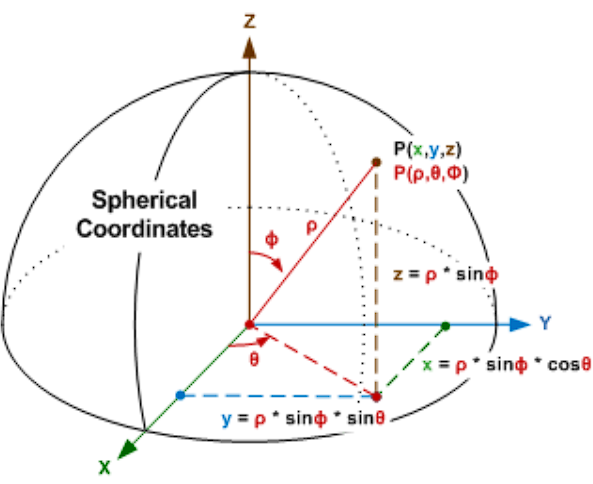

**Adding Cartesian Coordinates:**

In [6]:
cali_data['X'] = np.cos(cali_data.Latitude) * np.cos(cali_data.Longitude)
cali_data['Y'] = np.cos(cali_data.Latitude) * np.sin(cali_data.Longitude)
cali_data['Z'] = np.sin(cali_data.Latitude)

Now, we drop the original Latitude and Longitude columns since we have converted them.

In [7]:
cali_data.drop(["Latitude", "Longitude"], axis=1, inplace=True)
cali_data.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,X,Y,Z
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,-0.942013,-0.283278,0.179903
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,-0.942380,-0.293696,0.160195
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,-0.949556,-0.275223,0.150316
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,-0.952261,-0.265714,0.150316
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,-0.952261,-0.265714,0.150316


**Standardizing and Removing Outliers:**

We standardize the 'Population' feature and filter out outliers using a z-score threshold of 3.

In [8]:
scaler = StandardScaler()
cali_data['Population'] = scaler.fit_transform(cali_data[['Population']])
cali_data['Population'].min()

-1.2561225469018058

In [9]:
mask = (np.abs(stats.zscore(cali_data)) < 3).all(axis=1)
cali_data = cali_data[mask]
Price = Price[mask]

Let's re-plot the features against the target variable after outlier removal:

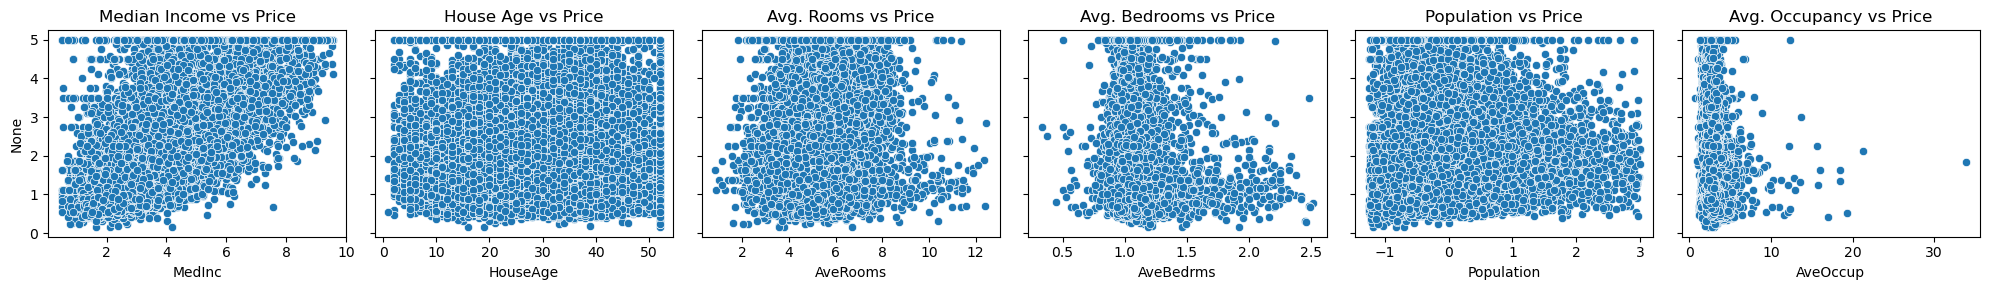

In [10]:
fig, axes = plt.subplots(1, 6, sharey=True, figsize=(20, 3))
sns.scatterplot(ax=axes[0], x=cali_data.MedInc, y=Price).set(title="Median Income vs Price")
sns.scatterplot(ax=axes[1], x=cali_data.HouseAge, y=Price).set(title="House Age vs Price")
sns.scatterplot(ax=axes[2], x=cali_data.AveRooms, y=Price).set(title="Avg. Rooms vs Price")
sns.scatterplot(ax=axes[3], x=cali_data.AveBedrms, y=Price).set(title="Avg. Bedrooms vs Price")
sns.scatterplot(ax=axes[4], x=cali_data.Population, y=Price).set(title="Population vs Price")
sns.scatterplot(ax=axes[5], x=cali_data.AveOccup, y=Price).set(title="Avg. Occupancy vs Price")
plt.tight_layout()
plt.show()

## 3. Model Initialization and Cost Computation

Before starting gradient descent, we split our data into training and testing sets.

**Data Splitting:**

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    cali_data, Price, test_size=0.25, random_state=42)

**Initializing Parameters:**

We initialize the bias (`b`) as 0 and the weights (`w`) randomly. The number of weights corresponds to the number of features in our processed dataset.

$$
\hat{y} = w^T x + b $$

In [12]:
b = 0
w = np.random.randn(cali_data.shape[1])
w  # Display the initialized weights

array([-0.21649883, -1.45425568,  0.18193172,  1.45018325,  0.35129453,
       -0.5891076 , -0.48014854,  1.17527858,  0.43157753])

**Defining the Cost Function:**

The cost function, which we aim to minimize using gradient descent, is the mean squared error:

\[
J(w, b) = \frac{1}{2m} \sum_{i=1}^{m} \left(y_i - (w^T x_i + b)\right)^2
\]

In [13]:
def compute_cost(x, y, w, b):
    cost = 0
    m = x.shape[0]
    for i in range(m):
        f_xi = np.dot(w, x[i]) + b
        cost += (y[i] - f_xi) ** 2
    return (1/(2*m)) * cost

In [14]:
# Compute and display the initial cost on training data
initial_cost = compute_cost(X_train.to_numpy(), y_train.to_numpy(), w, b)
print("Initial cost:", initial_cost)

Initial cost: 1164.2470092497326


## 4. Gradient Descent Implementation

We now implement gradient descent to iteratively update our weights and bias.

**Gradient Computation:**

The gradients for the weights and bias are computed as:

$$
\
\frac{\partial J}{\partial w_j} = \frac{1}{m} \sum_{i=1}^{m} \left( (w^T x_i + b) - y_i \right) x_{ij}
\
$$
$$
\
\frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^{m} \left( (w^T x_i + b) - y_i \right)
\
$$

In [15]:
def compute_gradient(x, y, w, b):
    m, n = x.shape
    dj_dw = np.zeros((n,))
    dj_db = 0.0

    for i in range(m):
        err = (np.dot(w, x[i]) + b) - y[i]
        for j in range(n):
            dj_dw[j] += err * x[i, j]
        dj_db += err
    return (dj_dw / m), (dj_db / m)

In [16]:
# Example: Compute gradients on training data
gradients = compute_gradient(X_train.to_numpy(), y_train.to_numpy(), w, b)
print("Gradients (weights, bias):", gradients)

Gradients (weights, bias): (array([ -163.87356746, -1525.16267818,  -229.00300962,   -47.31687096,
           7.01209417,  -131.43541593,    16.36933392,    21.44604176,
         -14.2895759 ]), -44.63743027450792)


**Gradient Descent Loop:**

We define a function that performs gradient descent for a specified number of iterations. During each iteration, the weights and bias are updated using the computed gradients.


In [17]:
def gradient_descent(x, y, w, b, num_iters, cost_function, gradient_function, alpha):
    J_history = []
    print("Starting gradient descent with initial cost:", cost_function(x, y, w, b))
    for i in range(num_iters):
        dj_dw, dj_db = gradient_function(x, y, w, b)

        # Update weights and bias
        w = w - alpha * dj_dw
        b = b - alpha * dj_db

        J_history.append(cost_function(x, y, w, b))

        if i % math.ceil(num_iters / 10) == 0:
            print(f"Iteration {i:4d}: Cost {J_history[-1]:8.2f}")

    return w, b, J_history

In [18]:
# Run gradient descent on the training data
w, b, J_history = gradient_descent(X_train.to_numpy(), y_train.to_numpy(), w, b, 1000, compute_cost, compute_gradient, 0.001)

Starting gradient descent with initial cost: 1164.2470092497326
Iteration    0: Cost     2.95
Iteration  100: Cost     0.69
Iteration  200: Cost     0.63
Iteration  300: Cost     0.58
Iteration  400: Cost     0.54
Iteration  500: Cost     0.51
Iteration  600: Cost     0.48
Iteration  700: Cost     0.46
Iteration  800: Cost     0.43
Iteration  900: Cost     0.42


## 5. Model Evaluation and Example Prediction

**Evaluating on the Test Set:**

After training, we compute the cost on the test set to evaluate our model's performance.

In [19]:
test_cost = compute_cost(X_test.to_numpy(), y_test.to_numpy(), w, b)
print("Test cost:", test_cost)

Test cost: 0.39543321396315506


**Example Prediction:**

We select an example from the test set to make a prediction.

_Suggested Visual:_  
Add a comparison chart or annotation to show the predicted versus actual value.

In [20]:
ex = X_test.iloc[1000]
ey = y_test.iloc[1000]
predicted_value = np.dot(ex, w) + b
print("Prediction error for example 1000:", predicted_value - ey)

Prediction error for example 1000: -0.028860108055037914


## Conclusion

In this notebook, we:

- Loaded and preprocessed the California Housing dataset.
- Converted geographical coordinates to Cartesian coordinates.
- Implemented linear regression from scratch using gradient descent.
- Evaluated the model on a test set.

**Further Improvements:**

- **Cross-Validation:** Incorporate k-fold cross-validation for more robust evaluation.
- **Learning Rate Optimization:** Experiment with adaptive learning rates or momentum.
- **Visualization:** Plot the cost function vs. iterations to visualize convergence.
- Include more plots (e.g., residual plots, cost convergence graphs) for deeper analysis.

_Thank you for reviewing this project!_  
 
